In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [2]:
from keras.applications.mobilenet_v3 import MobileNetV3Large

In [3]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [4]:
train_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/train"
valid_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/valid"
test_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/test"

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32, shuffle=False)


Found 1084 images belonging to 6 classes.
Found 310 images belonging to 6 classes.
Found 151 images belonging to 6 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


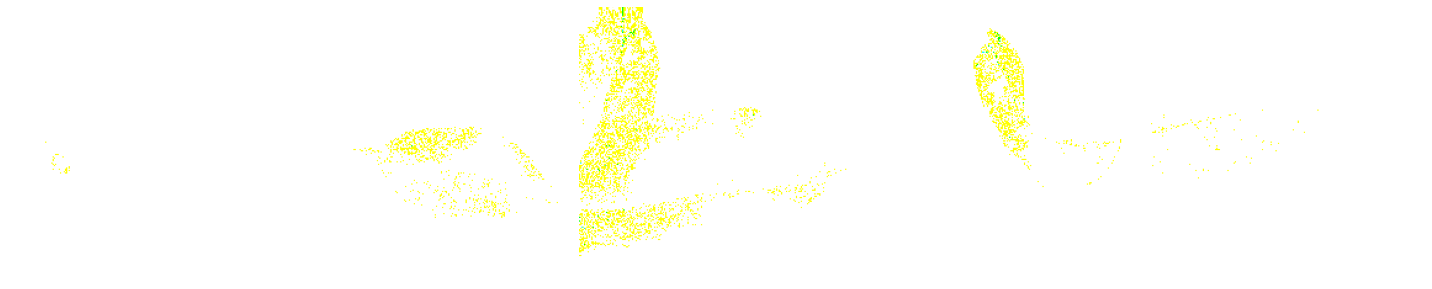

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
mobilenet_model = tf.keras.applications.MobileNetV3Large()

22675456/22661472 [==============================] - 0s 0us/step


In [10]:
mobilenet_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

In [11]:
for layer in mobilenet_model.layers:
  layer.trainable=False
mobilenet_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

In [12]:
x = mobilenet_model.layers[-2].output
output = Dense(units=6, activation='softmax')(x)
model = Model(inputs=mobilenet_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [14]:
model_path = '/content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Large_model_v1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=30,
  callbacks=callbacks_list
)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 3.1242 - accuracy: 0.1393 
Epoch 1: val_accuracy improved from -inf to 0.21613, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Large_model_v1.h5
34/34 [==============================] - 592s 17s/step - loss: 3.1242 - accuracy: 0.1393 - val_loss: 2.2189 - val_accuracy: 0.2161
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.0072 - accuracy: 0.3072
Epoch 2: val_accuracy improved from 0.21613 to 0.41290, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Large_model_v1.h5
34/34 [==============================] - 176s 5s/step - loss: 2.0072 - accuracy: 0.3072 - val_loss: 1.6107 - val_accuracy: 0.4129
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.5451 - accuracy: 0.4216
Epoch 3: val_accuracy improved from 0.41290 to 0.51935, saving model to /

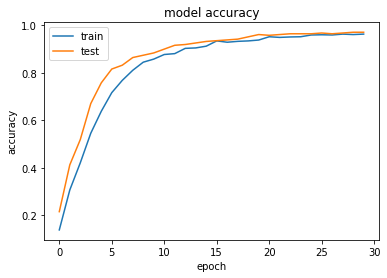

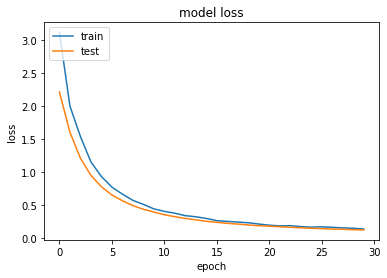

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9686
Epoch 1: val_accuracy did not improve from 0.97097
34/34 [==============================] - 180s 5s/step - loss: 0.1369 - accuracy: 0.9686 - val_loss: 0.1253 - val_accuracy: 0.9710
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9603
Epoch 2: val_accuracy did not improve from 0.97097
34/34 [==============================] - 177s 5s/step - loss: 0.1327 - accuracy: 0.9603 - val_loss: 0.1205 - val_accuracy: 0.9710
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9705
Epoch 3: val_accuracy improved from 0.97097 to 0.97419, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Large_model_v1.h5
34/34 [==============================] - 176s 5s/step - loss: 0.1316 - accuracy: 0.9705 - val_loss: 0.1172 - val_accuracy: 0.9742
Epoch 4/10
34/34 [===============

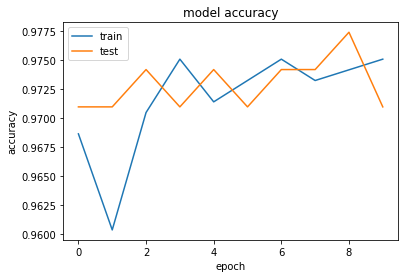

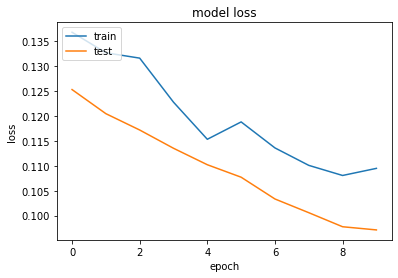

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9714
Epoch 1: val_accuracy did not improve from 0.97742
34/34 [==============================] - 185s 5s/step - loss: 0.1077 - accuracy: 0.9714 - val_loss: 0.0933 - val_accuracy: 0.9774
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 0.97742
34/34 [==============================] - 172s 5s/step - loss: 0.1019 - accuracy: 0.9779 - val_loss: 0.0914 - val_accuracy: 0.9774
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9714
Epoch 3: val_accuracy did not improve from 0.97742
34/34 [==============================] - 172s 5s/step - loss: 0.1056 - accuracy: 0.9714 - val_loss: 0.0904 - val_accuracy: 0.9774
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9806
Epoch 4: val_accuracy did not improve from 0.97742
34/34 [=======================

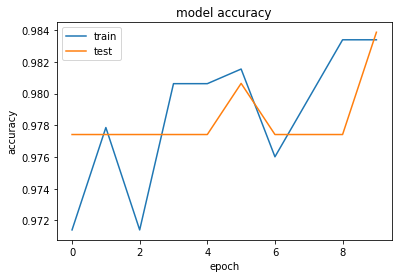

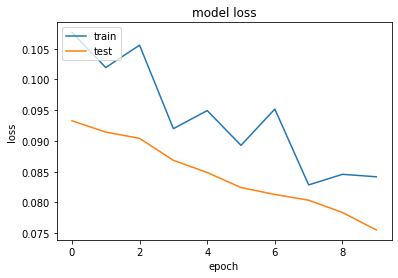

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
predictions = model.predict(x=test_batches, verbose=0)

In [22]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [23]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=rounded_predictions)

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.class_indices

{'Citrus Greasy Spot': 1,
 'Citrus canker': 0,
 'Citrus variegated chlorosis': 2,
 'Halo Blight': 3,
 'Mosaic': 4,
 'Nutritional Deficiency': 5}

Confusion matrix, without normalization
[[18  0  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0  0 55  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 22]]


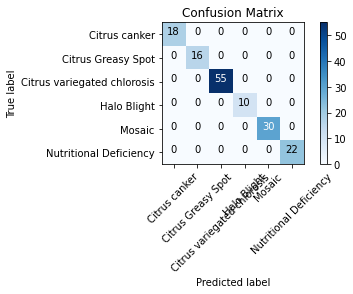

In [26]:
cm_plot_labels=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [27]:
from sklearn.metrics import classification_report

In [28]:
cr = classification_report(y_true=test_batches.classes, y_pred=rounded_predictions, target_names=cm_plot_labels)
print(cr)

                             precision    recall  f1-score   support

              Citrus canker       1.00      1.00      1.00        18
         Citrus Greasy Spot       1.00      1.00      1.00        16
Citrus variegated chlorosis       1.00      1.00      1.00        55
                Halo Blight       1.00      1.00      1.00        10
                     Mosaic       1.00      1.00      1.00        30
     Nutritional Deficiency       1.00      1.00      1.00        22

                   accuracy                           1.00       151
                  macro avg       1.00      1.00      1.00       151
               weighted avg       1.00      1.00      1.00       151

